# The linkage between the amplitude and phase of the seasonal cycle and Northern Hemisphere regional warming patterns

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Analysis
import xarray as xr
import numpy as np
from numpy.linalg import multi_dot
# from eofs.standard import Eof
from scipy.signal import butter, sosfiltfilt
import pandas as pd
import calendar
from datetime import timedelta
from scipy.stats import rankdata, linregress, boxcox, t
#import xesmf as xe
import statsmodels.api as sm
from scipy.optimize import nnls
from scipy.spatial import distance_matrix

# General
from glob import glob
import os
import string
from itertools import groupby
from operator import itemgetter
import time
from subprocess import check_call

# Geometry
import geopandas
from shapely.geometry import shape
from shapely.affinity import translate
import geocat.viz as gv

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
from matplotlib import colors
%matplotlib inline

# This project
from seasonal import constants, utils
from helpful_utilities import ncutils, general

/glade/work/mckinnon/conda-envs/kam-stats/lib/python3.9/site-packages/climlab/convection/akmaev_adjustment.py:142: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  Akmaev_adjustment = jit(signature_or_function=Akmaev_adjustment)
/glade/work/mckinnon/conda-envs/kam-stats/lib/python3.9/site-packages/xarray/core/missing.py:566: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/glade/work/mckinnon/conda-envs/kam-stats/lib/python3.9/site-packages/xarray/core/missing.py:567: FutureWarning: Passing method to Float64Index.get_loc is

In [3]:
# Suppress warnings: sometimes we do a < operation with nans which gives warnings
import warnings
warnings.simplefilter('ignore')

## Functions

## Filenames

In [4]:
version = 'revision2'

# These are the default options
# Mods can be made below with different versions
lower_lat = 30
upper_lat = 80
type_forcing = 'surface'  # surface or toa
# whether to mask ocean for forcing
domask_forcing = False
# whether to do organic mask based on seasonal R2 value
domask_R2 = False
R2_cutoff = 0.95
tropics_bound = 30
lon_avg = True

if version == 'toa':
    type_forcing = 'toa'
elif version == 'R2_mask':
    domask_R2 = True
    lower_lat = -60
    upper_lat = 80
elif version == 'SH':
    domask_R2 = True
    lower_lat = -60
    upper_lat = -30
elif version == 'ocean_mask':
    domask_forcing = True
elif version == 'local_forcing':
    lon_avg = False

glade_dir = '/glade/work/mckinnon/seasonal'
savedir = '%s/%s' % (glade_dir, version)
scratch_dir = '/glade/scratch/mckinnon/seasonal/%s' % version
if not os.path.isdir(savedir):
    cmd = 'mkdir -p %s' % savedir
    check_call(cmd.split())
    
if not os.path.isdir(scratch_dir):
    cmd = 'mkdir -p %s' % scratch_dir
    check_call(cmd.split())
    
figdir = '%s/%s/figs' % (glade_dir, version)
if not os.path.isdir(figdir):
    cmd = 'mkdir -p %s' % figdir
    check_call(cmd.split())
    
f_best = '/glade/work/mckinnon/BEST/Complete_TAVG_LatLong1.nc'
era5_sw_fname = '/glade/work/mckinnon/ERA5/month/ssr/era5_ssr.nc'

In [5]:
# season for trends (or ann for annual mean)
this_season = 'ann'

# SMILE info
smile_dir = '/gpfs/fs1/collections/cdg/data/CLIVAR_LE'
models = ('canesm2_lens', 'csiro_mk36_lens', 'gfdl_cm3_lens', 
          'mpi_lens', 'cesm_lens', 'ec_earth_lens', 'gfdl_esm2m_lens')

# years to calculate seasonal cycle
seasonal_years = 1950, 2020

# years to calculate trend
trend_years = 2021, 2050
nyrs_trend = trend_years[-1] - trend_years[0] + 1

# only use one sample to get mean state estimate
nboot = 1  # number of resamples for estimating uncertainty in trends and seasonal cycle

# EBM info
lams = np.linspace(0.5, 5, 100)  
mixing = np.linspace(0, 1, 100)
yrs_ramp = np.arange(1971, 2051)
yrs_stable = np.arange(2051, 2200)

# Plotting parameters
fontsize = 16
labelsize = 14
letters = string.ascii_lowercase

lat1x1 = np.arange(-89.5, 90, 1)
lon1x1 = np.arange(0.5, 360, 1)

In [6]:
# Forcing from historical and RCP8.5
# http://www.pik-potsdam.de/~mmalte/rcps/
rf = pd.read_csv('/glade/work/mckinnon/seasonal/data/rf.txt', header=None)
rf.index = np.arange(1765, 2101)
# change in radiative forcing during trend period
dF = (rf[rf.index == trend_years[-1]].values - rf[rf.index == trend_years[0]].values)[0][0]
# change in radiative forcing during ramp period
dF_long = (rf[rf.index == yrs_ramp[-1]].values - rf[rf.index == yrs_ramp[0]].values)[0][0]

# Calculate EBM predictions as a function of $m_{x,y}$ and $\lambda_{x,y}$

In [7]:
# gain and lag from m, lambda
da_gain_ebm, da_lag_ebm = utils.seasonal_solution(mixing, lams)

# change in temperature from m, lambda
T_anom_ocean_linear, T_anom_land_linear = utils.ramp_solution(mixing, lams, dF=dF_long, 
                                                              yrs_ramp=yrs_ramp, return_endmembers=True)
da_T_ebm_ramp = utils.ramp_solution(mixing, lams, dF=dF_long, yrs_ramp=yrs_ramp, return_endmembers=False)


# Calculate trend over trend years
da_trend_ebm = utils.calc_trend_season(da_T_ebm_ramp, trend_years, this_season)

# Calculate amplitude and phase of temperature for large ensembles, with bootstrapping

In [8]:
ds_seasonal_SMILES = []
for m in models:
    ds_seasonal = utils.calc_load_SMILE_seasonal_cycle(m, seasonal_years, nboot, savedir)
    ds_seasonal_SMILES.append(ds_seasonal) 

ds_seasonal_SMILES = xr.concat(ds_seasonal_SMILES, dim='model', coords='minimal') 
ds_seasonal_SMILES = ds_seasonal_SMILES.assign_coords({'model': list(models)}) 

# Calculate forcing

In [9]:
ds_seasonal_F_SMILES, sw_net_ts_SMILES = utils.get_SMILE_forcing(models, type_forcing, savedir, 
                                                                 nboot, seasonal_years, lon_avg=lon_avg,
                                                                 domask=domask_forcing, lower_lat=lower_lat, 
                                                                 upper_lat=upper_lat)

In [10]:
# Mask to desired domain
if domask_R2:
    ds_seasonal_SMILES = utils.do_mask(ds_seasonal_SMILES, lower_lat=lower_lat, upper_lat=upper_lat)
    R2_mask = (ds_seasonal_SMILES['R2'] > R2_cutoff) & (np.abs(ds_seasonal_SMILES.lat) > tropics_bound)
    ds_seasonal_SMILES = ds_seasonal_SMILES.where(R2_mask)
else:
    ds_seasonal_SMILES = utils.do_mask(ds_seasonal_SMILES)

# Calculate amplitude and phase of forcing, with bootstrapping, and gain and lag

In [11]:
da_gain_SMILE = ds_seasonal_SMILES['A']/ds_seasonal_F_SMILES['A']
da_lag_SMILE = ds_seasonal_SMILES['phi'] - ds_seasonal_F_SMILES['phi']

In [12]:
if domask_R2:
    da_gain_SMILE = utils.do_mask(da_gain_SMILE, lower_lat=lower_lat, upper_lat=upper_lat)
    da_lag_SMILE = utils.do_mask(da_lag_SMILE, lower_lat=lower_lat, upper_lat=upper_lat)

    da_gain_SMILE = da_gain_SMILE.where(R2_mask)
    da_lag_SMILE = da_lag_SMILE.where(R2_mask)
else:
    # Mask out ocean, Greenland
    da_gain_SMILE = utils.do_mask(da_gain_SMILE)
    da_lag_SMILE = utils.do_mask(da_lag_SMILE)

In [13]:
tmp = da_lag_SMILE.values
tmp[tmp < 0] += 365
da_lag_SMILE.values = tmp

In [14]:
# # check if outside of EBM solutions
ebm_hull = utils.get_EBM_hull(da_gain_ebm, da_lag_ebm)
da_in_hull = utils.points_in_hull(da_gain_SMILE, da_lag_SMILE, ebm_hull)
da_gain_SMILE_for_plots = da_gain_SMILE.copy()
da_lag_SMILE_for_plots = da_lag_SMILE.copy()
da_gain_SMILE = da_gain_SMILE.where(da_in_hull)
da_lag_SMILE = da_lag_SMILE.where(da_in_hull)

In [15]:
# Print out average R2
avg_R2 = ds_seasonal_SMILES['R2'].weighted(weights=np.cos(np.deg2rad(ds_seasonal_SMILES.lat))).mean()
print('Average variance explained by first harmonic: %0.4f' % avg_R2)

# Print spatial correlation between gain and lag
gain_lag_corr = xr.corr(da_gain_SMILE.mean(['model', 'sample']),
                        da_lag_SMILE.mean(['model', 'sample']))
print('Correlation between gain and lag maps (multi-model mean): %0.2f' % gain_lag_corr)

Average variance explained by first harmonic: 0.9902
Correlation between gain and lag maps (multi-model mean): -0.41


# Map from gain and lag to $m$, $\lambda$, and trend

If using a large nboot, this will take a long time.

In [16]:
ds_SMILE_EBM_all = []
for this_m in models:
    savename_SMILE = '%s/%s_dT_%04i-%04i_mix_lam_EBM_%i-samples.nc' % (savedir, this_m, 
                                                                       trend_years[0], trend_years[-1], 
                                                                       nboot)

    ds_SMILE = []

    for sample in range(nboot):
        if (sample % 10) == 0:
            print(this_m, sample)

        (this_da_T_pred,
         this_da_lam,
         this_da_mix) = utils.predict_with_ebm(da_gain_SMILE.sel({'model': this_m, 'sample': sample}),
                                               da_lag_SMILE.sel({'model': this_m, 'sample': sample}),
                                               da_gain_ebm,
                                               da_lag_ebm,
                                               da_trend_ebm)

        this_ds = xr.Dataset(data_vars={'dT': this_da_T_pred, 'mix': this_da_mix, 'lam': this_da_lam})
        ds_SMILE.append(this_ds)

    ds_SMILE = xr.concat(ds_SMILE, dim='sample')
    ds_SMILE = ds_SMILE.assign_coords({'sample': np.arange(nboot)})

        
    ds_SMILE_EBM_all.append(ds_SMILE)
    
ds_SMILE_EBM_all = xr.concat(ds_SMILE_EBM_all, dim='model', coords='minimal')
ds_SMILE_EBM_all = ds_SMILE_EBM_all.assign_coords({'model': list(models)})

canesm2_lens 0
csiro_mk36_lens 0
gfdl_cm3_lens 0
mpi_lens 0
cesm_lens 0
ec_earth_lens 0
gfdl_esm2m_lens 0


In [17]:
# Find what trend would look like with constant m or constant lambda
savename_m = '%s/dT_constant_m.nc' % savedir
savename_lam = '%s/dT_constant_lam.nc' % savedir
if (os.path.isfile(savename_m) & os.path.isfile(savename_lam)):
    da_SMILE_EBM_constant_m = xr.open_dataarray(savename_m)
    da_SMILE_EBM_constant_lam = xr.open_dataarray(savename_lam)
else:

    da_SMILE_EBM_constant_m = ds_SMILE_EBM_all['dT'].mean('sample').copy()
    da_SMILE_EBM_constant_lam = ds_SMILE_EBM_all['dT'].mean('sample').copy()
    _, nlat, nlon = da_SMILE_EBM_constant_lam.shape

    m_avg = ds_SMILE_EBM_all['mix'].weighted(weights=np.cos(np.deg2rad(ds_SMILE_EBM_all.lat)))
    m_avg = m_avg.mean(['lat', 'lon'])
    lam_avg = ds_SMILE_EBM_all['lam'].weighted(weights=np.cos(np.deg2rad(ds_SMILE_EBM_all.lat)))
    lam_avg = lam_avg.mean(['lat', 'lon'])

    # Constant m, find closest lambda
    for ct, this_m in enumerate(models):
        closest_m_idx = np.argmin(np.abs(mixing - m_avg.sel(model=this_m).mean('sample').values))
        lam_vals = ds_SMILE_EBM_all['lam'].sel(model=this_m).mean('sample')
        d = distance_matrix(lam_vals.values.flatten()[:, np.newaxis], lams[:, np.newaxis])
        min_loc = np.argmin(d, axis=-1)

        T_pred_vec = np.array([da_trend_ebm[ii, closest_m_idx] for ii in min_loc])
        T_pred_vec[np.isnan(lam_vals.values.flatten())] = np.nan

        da_SMILE_EBM_constant_m[ct, ...] = T_pred_vec.reshape((nlat, nlon))

    # Constant lambda, find closest m
    for ct, this_m in enumerate(models):
        closest_lam_idx = np.argmin(np.abs(lams - lam_avg.sel(model=this_m).mean('sample').values))
        m_vals = ds_SMILE_EBM_all['mix'].sel(model=this_m).mean('sample')
        d = distance_matrix(m_vals.values.flatten()[:, np.newaxis], mixing[:, np.newaxis])
        min_loc = np.argmin(d, axis=-1)

        T_pred_vec = np.array([da_trend_ebm[closest_lam_idx, ii] for ii in min_loc])
        T_pred_vec[np.isnan(m_vals.values.flatten())] = np.nan

        da_SMILE_EBM_constant_lam[ct, ...] = T_pred_vec.reshape((nlat, nlon))

    da_SMILE_EBM_constant_m.to_netcdf(savename_m)
    da_SMILE_EBM_constant_lam.to_netcdf(savename_lam)

# Get weighted lambda and associated trends

In [18]:
da_weighted_lam_inv = (ds_SMILE_EBM_all['mix']/ds_SMILE_EBM_all['lam'] + 
                       (1 - ds_SMILE_EBM_all['mix'])/ds_SMILE_EBM_all['lam'])
dT_eq = dF*da_weighted_lam_inv

# Calculate climate model predictions of temperature change

In [19]:
# ensemble mean
da_trend_SMILEs = utils.calc_load_SMILE_trends(models, trend_years, this_season, savedir)
# Mask to desired domain
if domask_R2:
    da_trend_SMILEs = utils.do_mask(da_trend_SMILEs, lower_lat=lower_lat, upper_lat=upper_lat)
    da_trend_SMILEs = da_trend_SMILEs.where(R2_mask)
else:
    da_trend_SMILEs = utils.do_mask(da_trend_SMILEs)

In [20]:
# resample ensemble members with replacement for uncertainty estimates
np.random.seed(123)
savename = '%s/bootstrapped_SMILE_trends_%s_%04i-%04i_%i-samples.nc' % (savedir, this_season, 
                                                             trend_years[0], trend_years[-1], nboot)

if os.path.isfile(savename):
    da_boot_SMILEs = xr.open_dataarray(savename)
else:
    # Get trend estimates from bootstrapping
    da_boot_SMILEs = []
    for kk in range(nboot):
        if kk % 100 == 0:
            print(kk)

        # resample the trends within each model ensemble to get new estimates
        boot_trends = []
        for this_m in models:
            trend_savename = '%s/%s_trend_%s_%i-%i.nc' % (savedir, this_m, this_season, 
                                                          trend_years[0], trend_years[-1])
            this_trend = xr.open_dataarray(trend_savename)
            this_trend['member'] = np.arange(len(this_trend['member']))
            this_trend = this_trend.sel({'member': np.random.choice(this_trend['member'], 
                                                                    len(this_trend['member']))})
            
            this_trend = this_trend.mean('member')
            boot_trends.append(this_trend)

        boot_trends = xr.concat(boot_trends, dim='model')
        boot_trends = boot_trends.assign_coords({'model': list(models)})
        da_boot_SMILEs.append(boot_trends)

    da_boot_SMILEs = xr.concat(da_boot_SMILEs, dim='sample')
    da_boot_SMILEs['sample'] = np.arange(nboot)

    da_boot_SMILEs.to_netcdf(savename)
    
if domask_R2:
    da_boot_SMILEs = utils.do_mask(da_boot_SMILEs, lower_lat=lower_lat, upper_lat=upper_lat)
    da_boot_SMILEs = da_boot_SMILEs.where(R2_mask)
else:
    da_boot_SMILEs = utils.do_mask(da_boot_SMILEs)


# Consider full trends as well as deviations from zonal average

In [21]:
if domask_R2:
    EBM_prediction_full = utils.do_mask(ds_SMILE_EBM_all['dT'], lower_lat=lower_lat, upper_lat=upper_lat)
    EBM_prediction_full = EBM_prediction_full.where(R2_mask)
else:
    EBM_prediction_full = utils.do_mask(ds_SMILE_EBM_all['dT'])    
EBM_prediction = EBM_prediction_full - EBM_prediction_full.mean('lon')

if domask_R2:
    lambda_prediction_full = utils.do_mask(dT_eq, lower_lat=lower_lat, upper_lat=upper_lat)
    lambda_prediction_full = lambda_prediction_full.where(R2_mask)
else:
    lambda_prediction_full = utils.do_mask(dT_eq) 
lambda_prediction = lambda_prediction_full - lambda_prediction_full.mean('lon')

if domask_R2:
    SMILE_prediction_full = utils.do_mask(da_boot_SMILEs, lower_lat=lower_lat, upper_lat=upper_lat)
    SMILE_prediction_full = SMILE_prediction_full.where(R2_mask)
else:
    SMILE_prediction_full = utils.do_mask(da_boot_SMILEs) 
SMILE_prediction = SMILE_prediction_full - SMILE_prediction_full.mean('lon')

# Calculate correlations between predictions, and magnitude of warming

In [22]:
rho_EBM_SMILEs_full = xr.corr(EBM_prediction_full.mean(['model', 'sample']), 
                              SMILE_prediction_full.mean(['model', 'sample']))
print('correlation between EBM and SMILE (full): %0.2f' % rho_EBM_SMILEs_full)

rho_feedback_SMILEs = xr.corr(SMILE_prediction.mean(['model', 'sample']), 
                              lambda_prediction.mean(['model', 'sample']))

rho_EBM_SMILEs = xr.corr(SMILE_prediction.mean(['model', 'sample']), 
                         EBM_prediction.mean(['model', 'sample']))

# print('rho: (feedback param, SMILEs): %0.2f' % rho_feedback_SMILEs)
print('correlation between EBM and SMILE (zonal): %0.2f' % rho_EBM_SMILEs)

delta_seasonal = EBM_prediction.mean(['model', 'sample']) - lambda_prediction.mean(['model', 'sample'])
zonal_mix = ds_SMILE_EBM_all['mix']
zonal_mix = zonal_mix - zonal_mix.mean('lon')
zonal_mix = zonal_mix.mean(['model', 'sample'])

rho_dev_mix = xr.corr(delta_seasonal, zonal_mix)

# print('rho: (EBM - feedback, mix): %0.2f' % rho_dev_mix)

# Average warming in each model
avg_warming_EBM = EBM_prediction_full.weighted(weights=np.cos(np.deg2rad(EBM_prediction_full.lat)))
avg_warming_EBM = avg_warming_EBM.mean(['lat', 'lon']).mean()

avg_warming_SMILE = SMILE_prediction_full.weighted(weights=np.cos(np.deg2rad(SMILE_prediction_full.lat)))
avg_warming_SMILE = avg_warming_SMILE.mean(['lat', 'lon']).mean()

print('average warming in EBM: %0.1f/%iy' % (avg_warming_EBM*nyrs_trend, nyrs_trend))
print('average warming in SMILEs: %0.1f/%iy' % (avg_warming_SMILE*nyrs_trend, nyrs_trend))

correlation between EBM and SMILE (full): 0.81
correlation between EBM and SMILE (zonal): 0.70
average warming in EBM: 0.6/30y
average warming in SMILEs: 1.8/30y


# Estimate degrees of freedom via EOFs of pooled covariance matrices across large ensemble trends

(1) with zonal mean

(2) without zonal mean

In [23]:
data_mask = ~np.isnan(da_boot_SMILEs[0, ...]).any(dim='model')

savename = '%s/dof_SMILE_trends_full_and_zonal.npz' % savedir

if os.path.isfile(savename):
    np_ds = np.load(savename)
    pooled_cov = np_ds['pooled_cov']
    pooled_cov_zonal = np_ds['pooled_cov_zonal']
    
else:
    
    pooled_cov = []
    pooled_cov_zonal = []
    for this_m in models:
        trend_savename = '%s/%s_trend_%s_%i-%i.nc' % (savedir, this_m, this_season, 
                                                      trend_years[0], trend_years[-1])
        
        this_trend = xr.open_dataarray(trend_savename)
        # mask to region of interest
        if domask_R2:
            this_trend = utils.do_mask(this_trend, lower_lat=lower_lat, upper_lat=upper_lat)
            this_trend = this_trend.where(R2_mask.sel(model=this_m).squeeze())
        else: 
            this_trend = utils.do_mask(this_trend)

        nm, nlat, nlon = this_trend.shape
        trend_vec = this_trend.values.reshape((nm, nlat*nlon))
        trend_vec = trend_vec[:, data_mask.values.flatten()]
        cov_mat = np.cov(trend_vec.T)
        pooled_cov.append(cov_mat)
        
        # for zonal patterns, remove zonal mean
        this_trend_zonal = this_trend - this_trend.mean('lon')
        trend_vec_zonal = this_trend_zonal.values.reshape((nm, nlat*nlon))
        trend_vec_zonal = trend_vec_zonal[:, data_mask.values.flatten()]
        cov_mat_zonal = np.cov(trend_vec_zonal.T)
        pooled_cov_zonal.append(cov_mat_zonal)
        
    pooled_cov = np.array(pooled_cov)
    pooled_cov_zonal = np.array(pooled_cov_zonal)
    
    # take average across models
    pooled_cov = np.mean(pooled_cov, axis=0)
    pooled_cov_zonal = np.mean(pooled_cov_zonal, axis=0)
    
    np.savez(savename, pooled_cov=pooled_cov, pooled_cov_zonal=pooled_cov_zonal)

# Calculate significance of full trend fields
# dof already removes two for correlation coefficient
dof = np.trace(pooled_cov)**2/(np.linalg.norm(pooled_cov, ord='fro')**2) - 2
n = pooled_cov.shape[0]
tstat = rho_EBM_SMILEs_full*np.sqrt(dof)/np.sqrt(1 - rho_EBM_SMILEs_full**2)
pval = t.sf(tstat, dof)  # alternative hypothesis: rho > 0
print('correlation of full fields: %0.2f' % rho_EBM_SMILEs_full)
print('pval: %0.4f' % pval)
print('dof: %0.2f' % (dof + 2))  # plus 2 because above I have taken out the two for the correlation

# and of zonal fields
dof = np.trace(pooled_cov_zonal)**2/(np.linalg.norm(pooled_cov_zonal, ord='fro')**2) - 2
n = pooled_cov_zonal.shape[0]
tstat = rho_EBM_SMILEs*np.sqrt(dof)/np.sqrt(1 - rho_EBM_SMILEs**2)
pval = t.sf(tstat, dof)  # alternative hypothesis: rho > 0
print('correlation of zonal fields: %0.2f' % rho_EBM_SMILEs)
print('pval: %0.4f' % pval)
print('dof: %0.2f' % (dof + 2))

correlation of full fields: 0.81
pval: 0.0051
dof: 8.51
correlation of zonal fields: 0.70
pval: 0.0076
dof: 11.11


In [24]:
x = EBM_prediction.mean(['model', 'sample']).values.flatten()
y = SMILE_prediction.mean(['model', 'sample']).values.flatten()
pl = ~np.isnan(x)
cov_x_y = np.dot(x[pl] - np.mean(x[pl]), y[pl] - np.mean(y[pl]))/(len(pl) - 1)
beta = np.cov(x[pl] - np.mean(x[pl]), y[pl] - np.mean(y[pl]))/np.var(x[pl])
beta2 = cov_x_y/np.var(x[pl])

beta1, _ = general.fit_OLS(x[pl], y[pl], add_intercept=False, remove_mean=True)
print('Slope from EBM to climate models: %0.3f' % beta1)

Slope from EBM to climate models: 1.244


# Figure 1: Seasonal cycle in models (gain, lag, R2)

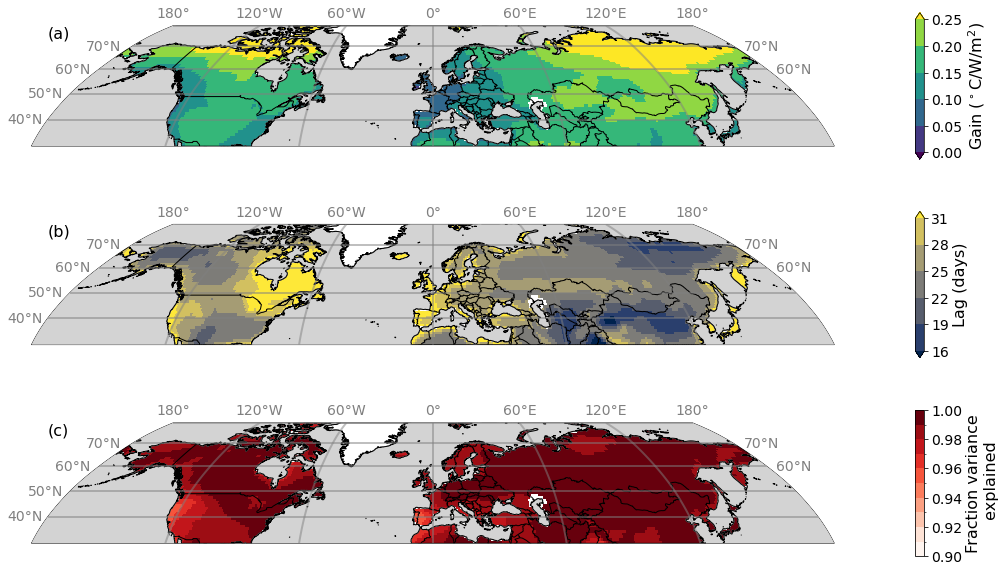

In [25]:
fig = plt.figure(figsize=(16, 10))

plotcrs = ccrs.Robinson()
fig.tight_layout()
gs = gridspec.GridSpec(5, 2, width_ratios=[0.9, 0.01], height_ratios=[1, 0.1, 1, 0.1, 1])

levels_gain = np.arange(0, 0.3, 0.05)
cmap_gain = plt.cm.viridis

levels_lag = np.arange(16, 33, 3)
cmap_lag = plt.cm.cividis

levels_R2 = np.arange(0.9, 1.005, 0.01)
cmap_R2 = plt.cm.Reds

for ct in range(3):
    if ct == 0:
        levels = levels_gain
        cmap = cmap_gain
        extend = 'both'
        clabel = r'Gain ($^\circ$C/W/m$^2$)'
        to_plot = da_gain_SMILE_for_plots.mean(['model', 'sample'])
    elif ct == 1:
        levels = levels_lag
        cmap = cmap_lag
        extend = 'both'
        clabel = 'Lag (days)'
        to_plot = da_lag_SMILE_for_plots.mean(['model', 'sample'])
    else:
        levels = levels_R2
        cmap = cmap_R2
        extend = 'neither'
        clabel = 'Fraction variance\n explained'
        to_plot = ds_seasonal_SMILES['R2'].mean(['model', 'sample'])
        
    ax = plt.subplot(gs[ct*2, 0], projection=plotcrs)
    ax.text(0.02, 0.9, '(%s)' % letters[ct], fontsize=fontsize, transform=ax.transAxes)
    ax.set_extent([-180, 180, lower_lat, upper_lat], ccrs.PlateCarree())

    sc = to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), 
                      levels=levels, cmap=cmap, 
                      add_colorbar=False, zorder=2, extend=extend)

    ax.coastlines(zorder=3)
    ax.add_feature(cfeature.OCEAN, color='lightgray', zorder=3)
    ax.add_feature(cfeature.LAND, color='white', zorder=1)
    ax.add_feature(cfeature.BORDERS, zorder=4)
    ax.add_feature(cfeature.COASTLINE, zorder=4)
    ax.set_title('')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='-', zorder=5)
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': labelsize, 'color': 'gray', 'rotation': 0}
    gl.ylabel_style = {'size': labelsize, 'color': 'gray'}

    cax = plt.subplot(gs[ct*2, 1])
    cb = plt.colorbar(sc, cax=cax, orientation='vertical')
    cb.ax.tick_params(labelsize=labelsize)
    cb.set_label(clabel, fontsize=fontsize)


plt.savefig('%s/gain_lag_R2_models.png' % (figdir), dpi=300, bbox_inches='tight')

# Figure 2: gain, lag, and dT in models

Bin models by gain, lag, and show average change in temperature in each bin. Area-weight before averaging.

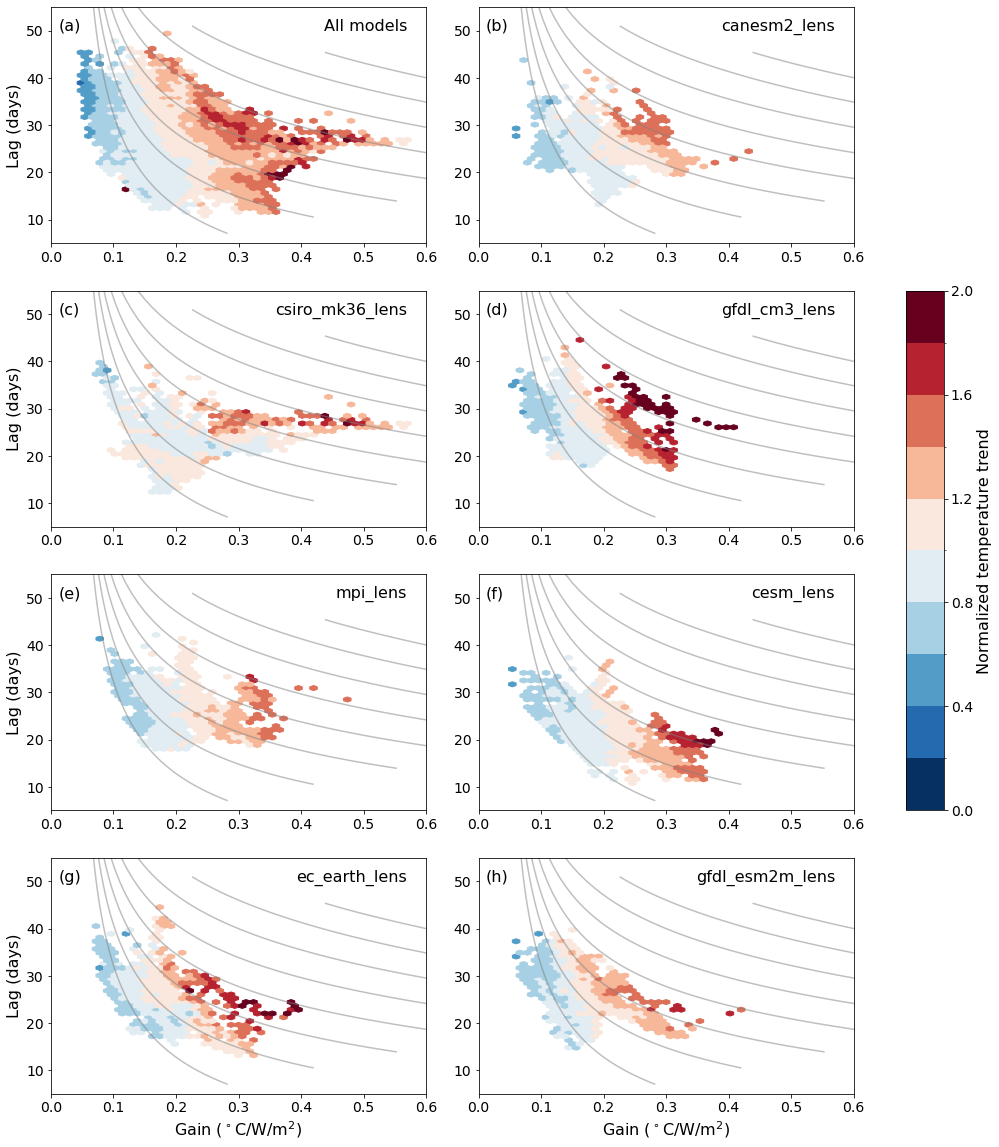

In [26]:
fig = plt.figure(figsize=(16, 20))
fig.tight_layout()
gs = gridspec.GridSpec(4, 3, width_ratios=[1, 1, 0.1], height_ratios=np.ones(4, ))

cmap = plt.cm.RdBu_r
levels = np.arange(0, 2.1, 0.2)
norm = colors.BoundaryNorm(levels, cmap.N)
nbins = 50
extent = (0, 0.6, 10, 55)
mincnt = 5

# levels_EBM = np.arange(0.1, 2, 0.2)
# TMP TMP TMP
levels_EBM = np.arange(0, 3, 0.2)

for ct in range(8):
    if ct == 0:
        use_model = models
    else:
        use_model = models[ct - 1]
        
    col_ct = ct % 2
    row_ct = int(np.floor(ct / 2))                         
    ax = plt.subplot(gs[row_ct, col_ct])

    # Do hexbin for EM or each model
    x = da_gain_SMILE_for_plots.mean('sample').sel(model=np.isin(models, use_model)).values.flatten()
    y = da_lag_SMILE_for_plots.mean('sample').sel(model=np.isin(models, use_model)).values.flatten()
    # normalize each model's prediction with the area-weighted average 
    dT = SMILE_prediction_full.sel(model=np.isin(models, use_model)).mean('sample')
    dT_avg = dT.weighted(weights=np.cos(np.deg2rad(dT.lat))).mean(['lat', 'lon'])
    dT_norm = (dT/dT_avg).values.flatten()

    # get weights in order to area-weight each bin
    weights = np.cos(np.deg2rad(dT.lat))
    da_ones = dT.copy(data=np.ones((dT.shape)))
    da_ones = da_ones.where(~np.isnan(dT))
    da_ones_w = (da_ones*weights).values.flatten()

    # pull out information for hexbin in order to do weighted average
    coll_weighted = ax.hexbin(x, y, dT_norm*da_ones_w, 
                              gridsize=nbins, mincnt=mincnt, reduce_C_function=np.sum, 
                              visible=False, extent=extent)

    offsets_weighted = coll_weighted.get_offsets()
    arr_weighted = coll_weighted.get_array()

    coll_weights = ax.hexbin(x, y, da_ones_w, 
                             gridsize=nbins, mincnt=mincnt, reduce_C_function=np.sum, 
                             visible=False, extent=extent)
    offsets_weights = coll_weights.get_offsets()
    arr_weights = coll_weights.get_array()


    sc = ax.hexbin(offsets_weights[:, 0], offsets_weights[:, 1], 
                   C=arr_weighted/arr_weights, gridsize=nbins, extent=extent,
                   cmap=cmap, norm=norm)

    cs = ax.contour(da_gain_ebm.values, da_lag_ebm.values, nyrs_trend*da_trend_ebm.values,
                    levels=levels_EBM, colors='gray', alpha=0.5, lw=1)
    ax.set_xlim(0, 0.6)
    ax.set_ylim(5, 55)
    if col_ct == 0:
        ax.set_ylabel('Lag (days)', fontsize=fontsize)
    if row_ct == 3:
        ax.set_xlabel(r'Gain ($^\circ$C/W/m$^2$)', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.text(0.02, 0.9, '(%s)' % letters[ct], fontsize=fontsize, transform=ax.transAxes)
    if ct == 0:
        ax.text(0.95, 0.9, '%s' % 'All models', fontsize=fontsize, 
                transform=ax.transAxes, horizontalalignment='right')
    else:
        ax.text(0.95, 0.9, '%s' % models[ct - 1], fontsize=fontsize, 
                transform=ax.transAxes, horizontalalignment='right')
    
cax = plt.subplot(gs[1:-1, -1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical')
cb.ax.tick_params(labelsize=labelsize)
cb.set_label('Normalized temperature trend', fontsize=fontsize)
    
plt.savefig('%s/models_gain_lag_dT.png' % figdir, dpi=300, bbox_inches='tight')

# Figure 3: schematic

# Figure 4: m/lambda map to gain/lag

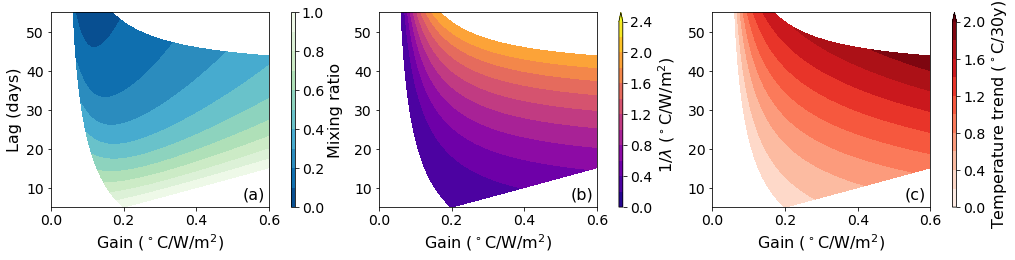

In [27]:
lam_mat = np.repeat(lams[:, np.newaxis], len(mixing), axis=-1)
mix_mat = np.repeat(mixing[np.newaxis, :], len(lams), axis=0)

fig = plt.figure(figsize=(14, 3.5), constrained_layout=True)
gs = fig.add_gridspec(1, 5, width_ratios=[1, 0.02, 1, 0.02, 1])
levels = np.arange(0, 1.01, 0.1)
# gain and lag to m
ax = fig.add_subplot(gs[0, 0])

cs = ax.contourf(da_gain_ebm.values, da_lag_ebm.values, mix_mat,
                levels=levels, extend='neither', cmap=plt.cm.GnBu_r)
ax.set_xlim(0, 0.6)
ax.set_ylim(5, 55)
ax.set_ylabel(r'Lag (days)', fontsize=fontsize)
#ax.plot(ebm_hull[:, 0], ebm_hull[:, 1] ,'-sk')
#ax.plot(da_gain_SMILE.values.flatten(), da_lag_SMILE.values.flatten(), 'r.', alpha=0.1)

ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r'Gain ($^\circ$C/W/m$^2$)', fontsize=fontsize)
ax.text(0.88, 0.04, '(a)', fontsize=fontsize, transform=ax.transAxes)

cb = fig.colorbar(cs, ax=ax, aspect=50)
cb.ax.tick_params(labelsize=labelsize)
cb.set_label('Mixing ratio', fontsize=fontsize)

# gain and lag to lambda
ax = fig.add_subplot(gs[0, 2])
levels = np.arange(0, 2.6, 0.2)

cs = ax.contourf(da_gain_ebm.values, da_lag_ebm.values, 1/lam_mat,
                levels=levels, extend='max', cmap=plt.cm.plasma)
ax.set_xlim(0, 0.6)
ax.set_ylim(5, 55)
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r'Gain ($^\circ$C/W/m$^2$)', fontsize=fontsize)
#ax.set_ylabel(r'Lag (days)', fontsize=fontsize)

ax.text(0.88, 0.04, '(b)', fontsize=fontsize, transform=ax.transAxes)
cb = fig.colorbar(cs, ax=ax, aspect=50)
cb.ax.tick_params(labelsize=labelsize)
cb.set_label('1/$\lambda$ ($^\circ$C/W/m$^2$)', fontsize=fontsize)

# gain and lag to dT
ax = fig.add_subplot(gs[0, 4])
levels = np.arange(0, 2.1, 0.2)

cs = ax.contourf(da_gain_ebm.values, da_lag_ebm.values, nyrs_trend*da_trend_ebm.values,
                levels=levels, extend='max', cmap=plt.cm.Reds)
# ax.set_xlim(0.02, 0.6)
# ax.set_ylim(10, 55)
ax.set_xlim(0, 0.6)
ax.set_ylim(5, 55)
ax.tick_params(labelsize=labelsize)
ax.set_xlabel(r'Gain ($^\circ$C/W/m$^2$)', fontsize=fontsize)
#ax.set_ylabel(r'Lag (days)', fontsize=fontsize)

ax.text(0.88, 0.04, '(c)', fontsize=fontsize, transform=ax.transAxes)
cb = fig.colorbar(cs, ax=ax, aspect=50)
cb.ax.tick_params(labelsize=labelsize)
cb.set_label('Temperature trend ($^\circ$C/%iy)' % nyrs_trend, fontsize=fontsize)

plt.savefig('%s/ebm_gain_lag_dT_parameters.png' % figdir, dpi=200, bbox_inches='tight')


# Figure 5: full map of EBM and SMILE predictions + m + lambda

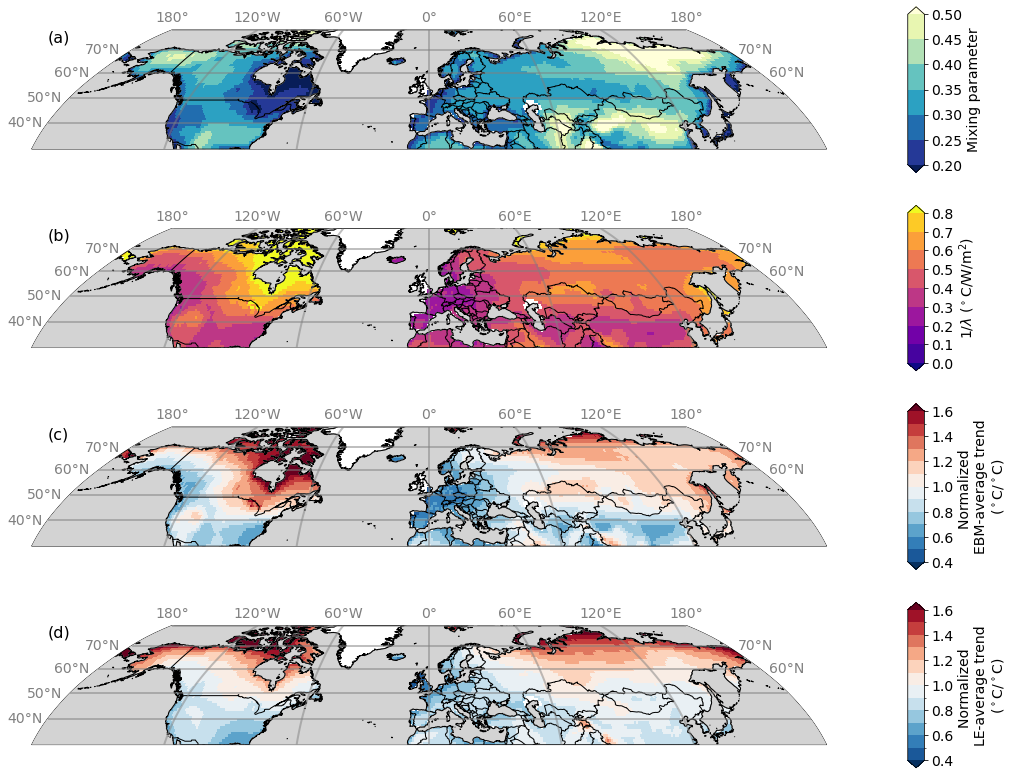

In [28]:
fig = plt.figure(figsize=(16, 14))

plotcrs = ccrs.Robinson()
fig.tight_layout()
gs = gridspec.GridSpec(4, 2, width_ratios=[0.95, 0.02], height_ratios=[1, 1, 1, 1])

for ct in range(4):

    if ct == 0:
        to_plot = ds_SMILE_EBM_all['mix'].mean(['model', 'sample'])
        clabel = 'Mixing parameter'
        levels = np.arange(0.2, 0.51, 0.05)
        cmap = plt.cm.YlGnBu_r
    elif ct == 1:
        to_plot = 1/(ds_SMILE_EBM_all['lam'].mean(['model', 'sample']))
        clabel = r'1/$\lambda$ ($^\circ$C/W/m$^2$)'
        levels = np.arange(0, 0.9, 0.1)
        cmap = plt.cm.plasma
    elif ct == 2:
        to_plot = (nyrs_trend*EBM_prediction_full.mean(['model', 'sample']))
        clabel = 'Normalized \nEBM-average trend\n' r'($^\circ$C/$^\circ$C)'
        levels = np.arange(0.4, 1.7, 0.1)
        cmap = plt.cm.RdBu_r
    elif ct == 3:
        to_plot = (nyrs_trend*SMILE_prediction_full.mean(['model', 'sample']))
        clabel = 'Normalized \nLE-average trend\n' r'($^\circ$C/$^\circ$C)'
        levels = np.arange(0.4, 1.7, 0.1)
        cmap = plt.cm.RdBu_r

    if ct >= 2:
        avg_val = to_plot.weighted(weights=np.cos(np.deg2rad(to_plot.lat))).mean(['lat', 'lon'])
        to_plot /= avg_val
    ax = plt.subplot(gs[ct, 0], projection=plotcrs)
    
    if domask_R2:
        ax.set_extent([-180, 180, lower_lat, upper_lat], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, 30, 80], ccrs.PlateCarree())
        
    sc = to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), 
                      levels=levels, cmap=cmap, add_colorbar=False, 
                      zorder=2, extend='both')

    ax.coastlines(zorder=3)
    ax.add_feature(cfeature.OCEAN, color='lightgray', zorder=3)
    ax.add_feature(cfeature.LAND, color='white', zorder=1)
    ax.add_feature(cfeature.BORDERS, zorder=4)
    ax.add_feature(cfeature.COASTLINE, zorder=4)

    ax.text(0.02, 0.9, '(%s)' % letters[ct], fontsize=fontsize, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='-', zorder=5)
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': labelsize, 'color': 'gray', 'rotation': 0}
    gl.ylabel_style = {'size': labelsize, 'color': 'gray', 'rotation': 0}

    cax = plt.subplot(gs[ct, 1])
    cb = plt.colorbar(sc, cax=cax, orientation='vertical')
    cb.ax.tick_params(labelsize=labelsize)
    cb.set_label(clabel, fontsize=labelsize)
    ax.set_title('')

plt.savefig('%s/all_full_maps.png' % figdir, dpi=300, bbox_inches='tight')

# Figure 6: latitudinal profiles of trends

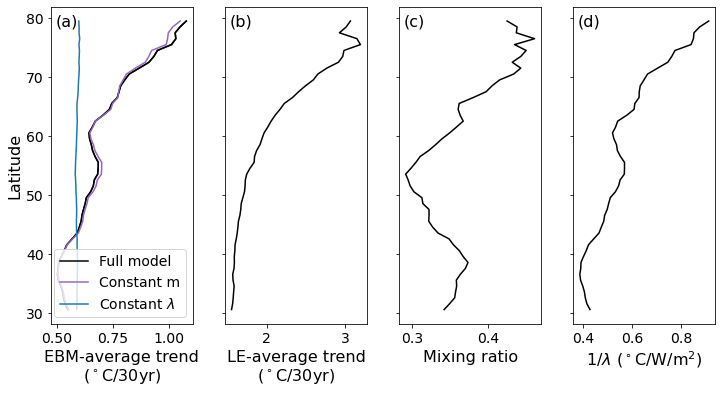

In [29]:
fig, axes = plt.subplots(ncols=4, figsize=(10, 5), sharey=True)
fig.tight_layout(w_pad=1)


for ct in range(4):
    if ct == 0:
        to_plot = (nyrs_trend*EBM_prediction_full.mean(['model', 'sample']))
        clabel = 'EBM-average trend\n' r'($^\circ$C/%iyr)' % nyrs_trend
    elif ct == 1:
        to_plot = (nyrs_trend*SMILE_prediction_full.mean(['model', 'sample']))
        clabel = 'LE-average trend\n' r'($^\circ$C/%iyr)' % nyrs_trend
    elif ct == 2:
        to_plot = ds_SMILE_EBM_all['mix'].mean(['model', 'sample'])
        clabel = 'Mixing ratio'
    elif ct == 3:
        to_plot = 1/(ds_SMILE_EBM_all['lam'].mean(['model', 'sample']))
        clabel = r'1/$\lambda$ ($^\circ$C/W/m$^2$)'
        

    ax = axes[ct]
    to_plot.mean('lon').plot.line(ax=ax, y='lat', color='k')


    if ct == 0:
        to_plot.mean('lon').plot.line(ax=ax, y='lat', color='k', label='Full model')
        (nyrs_trend*da_SMILE_EBM_constant_m).mean('model').mean('lon').plot.line(ax=ax, 
                                                                                 y='lat', 
                                                                                 color='tab:purple',
                                                                                 label='Constant m')
        (nyrs_trend*da_SMILE_EBM_constant_lam).mean('model').mean('lon').plot.line(ax=ax, 
                                                                                   y='lat', 
                                                                                   color='tab:blue',
                                                                                   label=r'Constant $\lambda$')

        ax.legend(fontsize=labelsize, loc='lower right')
        
    ax.tick_params(labelsize=labelsize)
    if ct == 0:
        ax.set_ylabel('Latitude', fontsize=fontsize)
    else:
        ax.set_ylabel('')
        
    ax.text(0.03, 0.94, '(%s)' % letters[ct], fontsize=fontsize, transform=ax.transAxes)
    ax.set_title('')
    ax.set_xlabel(clabel, fontsize=fontsize)
    
plt.savefig('%s/lat_profiles.png' % figdir, bbox_inches='tight', dpi=300)


In [30]:
# print polar amplification values
lat_weights = np.cos(np.deg2rad(EBM_prediction_full.lat))
EBM_meridional = EBM_prediction_full.mean(['model', 'sample', 'lon'])
SMILE_meridional = SMILE_prediction_full.mean(['model', 'sample', 'lon'])
EBM_highlat = EBM_meridional.sel(lat=slice(60, 80)).weighted(weights=lat_weights).mean('lat')
EBM_lowlat = EBM_meridional.sel(lat=slice(30, 50)).weighted(weights=lat_weights).mean('lat')
EBM_PA = EBM_highlat/EBM_lowlat

SMILE_highlat = SMILE_meridional.sel(lat=slice(60, 80)).weighted(weights=lat_weights).mean('lat')
SMILE_lowlat = SMILE_meridional.sel(lat=slice(30, 50)).weighted(weights=lat_weights).mean('lat')
SMILE_PA = SMILE_highlat/SMILE_lowlat

print('EBM polar amplification factor: %0.2f' % EBM_PA)
print('SMILE polar amplification factor: %0.2f' % SMILE_PA)

EBM polar amplification factor: 1.45
SMILE polar amplification factor: 1.56


In [31]:
EBM_highlat

<xarray.DataArray 'dT' ()>
array(0.0270427)
Coordinates:
    height   float64 2.0

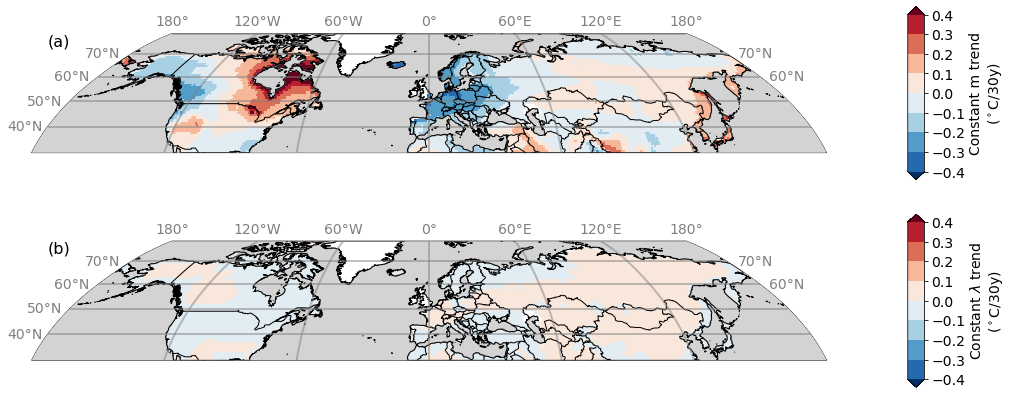

In [32]:
fig = plt.figure(figsize=(16, 7))

plotcrs = ccrs.Robinson()
fig.tight_layout()
gs = gridspec.GridSpec(2, 2, width_ratios=[0.95, 0.02], height_ratios=[1, 1])

levels = 2*np.arange(-0.2, 0.21, 0.05)
cmap = plt.cm.RdBu_r

for ct in range(2):
    if ct == 0:
        to_plot = (nyrs_trend*da_SMILE_EBM_constant_m.mean(['model']))
        clabel = 'Constant m trend\n' r'($^\circ$C/%iy)' % nyrs_trend
    elif ct == 1:
        to_plot = (nyrs_trend*da_SMILE_EBM_constant_lam.mean(['model']))
        clabel = 'Constant $\lambda$ trend\n' r'($^\circ$C/%iy)' % nyrs_trend

    to_plot = to_plot - to_plot.mean('lon')
    ax = plt.subplot(gs[ct, 0], projection=plotcrs)
    if domask_R2:
        ax.set_extent([-180, 180, lower_lat, upper_lat], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, 30, 80], ccrs.PlateCarree())

    sc = to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), 
                      levels=levels, cmap=cmap, add_colorbar=False, 
                      zorder=2, extend='both')

    ax.coastlines(zorder=3)
    ax.add_feature(cfeature.OCEAN, color='lightgray', zorder=3)
    ax.add_feature(cfeature.LAND, color='white', zorder=1)
    ax.add_feature(cfeature.BORDERS, zorder=4)
    ax.add_feature(cfeature.COASTLINE, zorder=4)

    ax.text(0.02, 0.9, '(%s)' % letters[ct], fontsize=fontsize, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='-', zorder=5)
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': labelsize, 'color': 'gray', 'rotation': 0}
    gl.ylabel_style = {'size': labelsize, 'color': 'gray', 'rotation': 0}

    cax = plt.subplot(gs[ct, 1])
    cb = plt.colorbar(sc, cax=cax, orientation='vertical')
    cb.ax.tick_params(labelsize=labelsize)
    cb.set_label(clabel, fontsize=labelsize)
    ax.set_title('')

plt.savefig('%s/zonal_maps_constant_params.png' % figdir, dpi=300, bbox_inches='tight')

# Figure 7: zonal EBM and SMILE predictions

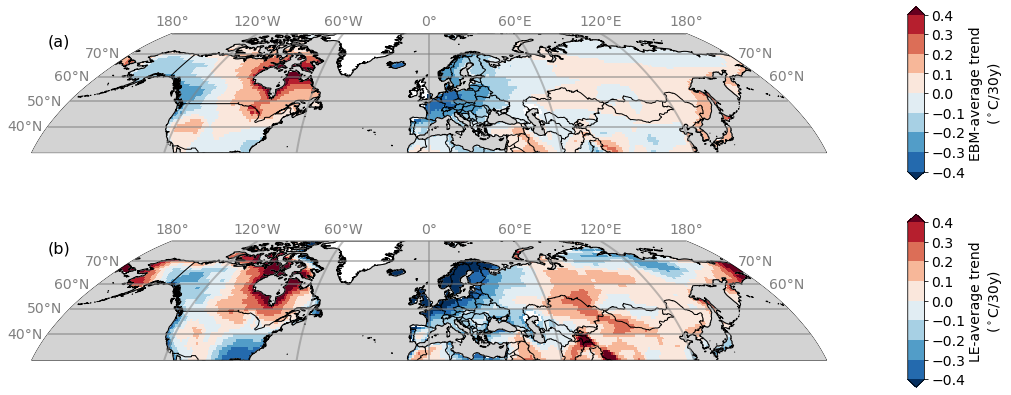

In [33]:
fig = plt.figure(figsize=(16, 7))

plotcrs = ccrs.Robinson()
fig.tight_layout()
gs = gridspec.GridSpec(2, 2, width_ratios=[0.95, 0.02], height_ratios=[1, 1])

levels = 2*np.arange(-0.2, 0.21, 0.05)
cmap = plt.cm.RdBu_r

for ct in range(2):
    if ct == 0:
        to_plot = (nyrs_trend*EBM_prediction.mean(['model', 'sample']))
        clabel = 'EBM-average trend\n' r'($^\circ$C/%iy)' % nyrs_trend
    elif ct == 1:
        to_plot = (nyrs_trend*SMILE_prediction.mean(['model', 'sample']))
        clabel = 'LE-average trend\n' r'($^\circ$C/%iy)' % nyrs_trend


    ax = plt.subplot(gs[ct, 0], projection=plotcrs)
    if domask_R2:
        ax.set_extent([-180, 180, lower_lat, upper_lat], ccrs.PlateCarree())
    else:
        ax.set_extent([-180, 180, 30, 80], ccrs.PlateCarree())

    sc = to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), 
                      levels=levels, cmap=cmap, add_colorbar=False, 
                      zorder=2, extend='both')

    ax.coastlines(zorder=3)
    ax.add_feature(cfeature.OCEAN, color='lightgray', zorder=3)
    ax.add_feature(cfeature.LAND, color='white', zorder=1)
    ax.add_feature(cfeature.BORDERS, zorder=4)
    ax.add_feature(cfeature.COASTLINE, zorder=4)

    ax.text(0.02, 0.9, '(%s)' % letters[ct], fontsize=fontsize, transform=ax.transAxes)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='-', zorder=5)
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': labelsize, 'color': 'gray', 'rotation': 0}
    gl.ylabel_style = {'size': labelsize, 'color': 'gray', 'rotation': 0}

    cax = plt.subplot(gs[ct, 1])
    cb = plt.colorbar(sc, cax=cax, orientation='vertical')
    cb.ax.tick_params(labelsize=labelsize)
    cb.set_label(clabel, fontsize=labelsize)
    ax.set_title('')

plt.savefig('%s/all_zonal_maps.png' % figdir, dpi=300, bbox_inches='tight')

# Figure ?: forcing

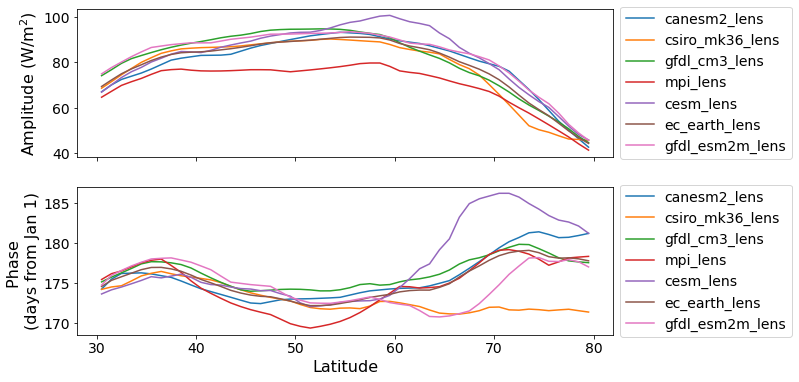

In [34]:
fig, ax = plt.subplots(figsize=(12, 6), nrows=2, sharex=True)

for this_m in models:
    to_plot_amp = ds_seasonal_F_SMILES['A'].sel({'model': this_m, 
                                                 'lat': slice(lower_lat, upper_lat)}).mean('sample')
    to_plot_amp.plot.line(ax=ax[0], label=this_m)
    
    to_plot_phase = ds_seasonal_F_SMILES['phi'].sel({'model': this_m, 
                                                     'lat': slice(lower_lat, upper_lat)}).mean('sample')
    to_plot_phase.plot.line(ax=ax[1], label=this_m)
    
for a in ax:
    box = a.get_position()
    a.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    a.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=labelsize)
    a.set_title('')
    a.tick_params(labelsize=labelsize)
    
ax[0].set_xlabel('', fontsize=fontsize)
ax[0].set_ylabel(r'Amplitude (W/m$^2$)', fontsize=fontsize)
ax[1].set_ylabel('Phase \n(days from Jan 1)', fontsize=fontsize)
ax[1].set_xlabel('Latitude', fontsize=fontsize) 
plt.savefig('%s/forcing_lat_sw_models.png' % (figdir), dpi=300, bbox_inches='tight')